In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('../data/extraccion_cerveza_refrigerantes.csv', sep=';')
data.columns = data.columns.str.lower()

data = data.drop(columns=['cant_vta', 'qtd_conteudo_sku'])
data = data.rename(columns={'pdv_anonimizado': 'pdv_codigo', 'nome_sku': 'nombre_sku', 'vol_vta': 'cant_vta'})
data = data.sort_values(by=['pdv_codigo','codigo_barras_sku', 'fecha_comercial' ])

# number of pdvs
print(f"Number of pdvs: {data['pdv_codigo'].nunique()}")
print(f"Number of dates: {data['fecha_comercial'].nunique()}. From {data['fecha_comercial'].min()} to {data['fecha_comercial'].max()}")
print(f"Number of products: {data['codigo_barras_sku'].nunique()}")
print(f"Shape: {data.shape}")
data.head()

Number of pdvs: 30
Number of dates: 737. From 2022-12-01 to 2024-12-10
Number of products: 1121
Shape: (3939181, 7)


,pdv_codigo,fecha_comercial,codigo_barras_sku,nombre_sku,imp_vta,cant_vta,stock
983233,1,2022-12-23,78905351,CERVEJA ORIGINAL DESCARTAVEL 600ML,33.96,2400.0,NaN
1236665,1,2022-12-24,78905351,CERVEJA ORIGINAL DESCARTAVEL 600ML,59.43,4200.0,NaN
2123779,1,2022-12-27,78905351,CERVEJA ORIGINAL DESCARTAVEL 600ML,8.49,600.0,NaN
1054464,1,2022-12-30,78905351,CERVEJA ORIGINAL DESCARTAVEL 600ML,42.45,3000.0,NaN
1105478,1,2022-12-31,78905351,CERVEJA ORIGINAL DESCARTAVEL 600ML,110.37,7800.0,NaN


# Data exploration

## Unique combinations

In [3]:
unique_combinations = data[['pdv_codigo', 'codigo_barras_sku']].drop_duplicates()
unique_combinations

,pdv_codigo,codigo_barras_sku
983233,1,78905351
1287449,1,78905498
3617671,1,78908901
2899316,1,78909045
3888379,1,78912939
...,...,...
3167828,30,8412598003370
1649251,30,8412598034213
686365,30,8712000025649
2194687,30,17898915949190


## Distribution of product by pdv

/var/folders/g4/21kk_yqn4h75mgg_8hcjcsx80000gn/T/ipykernel_9120/899439735.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pdvs_by_pdv = pdvs_by_pdv.groupby('classification').size().reset_index(name='count_pdvs')


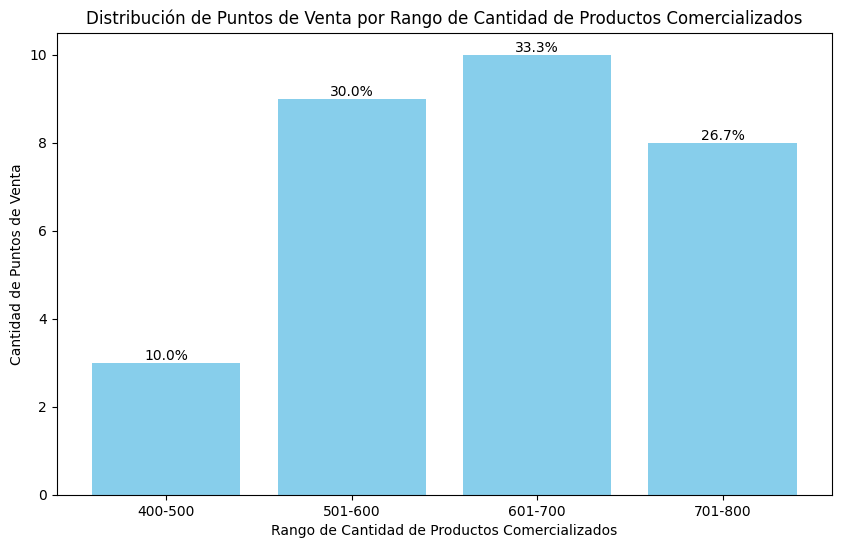

In [4]:
pdvs_by_pdv = data.groupby('pdv_codigo')['codigo_barras_sku'].nunique().reset_index().sort_values(by='codigo_barras_sku', ascending=False)
labels = ['400-500', '501-600', '601-700', '701-800']
bins = [400, 500, 600, 700, 800]
pdvs_by_pdv['classification'] = pd.cut(pdvs_by_pdv['codigo_barras_sku'], bins=bins, labels=labels, right=False)
pdvs_by_pdv = pdvs_by_pdv.groupby('classification').size().reset_index(name='count_pdvs')
pdvs_by_pdv

total_pdvs =pdvs_by_pdv['count_pdvs'].sum()
pdvs_by_pdv['percentage'] = (pdvs_by_pdv['count_pdvs'] / total_pdvs) * 100

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(pdvs_by_pdv['classification'], pdvs_by_pdv['count_pdvs'], color='skyblue')

for bar, porcentaje in zip(bars, pdvs_by_pdv['percentage']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{porcentaje:.1f}%', ha='center', va='bottom')

ax.set_xlabel('Rango de Cantidad de Productos Comercializados')
ax.set_ylabel('Cantidad de Puntos de Venta')
ax.set_title('Distribución de Puntos de Venta por Rango de Cantidad de Productos Comercializados')
plt.show()

## Sales per period

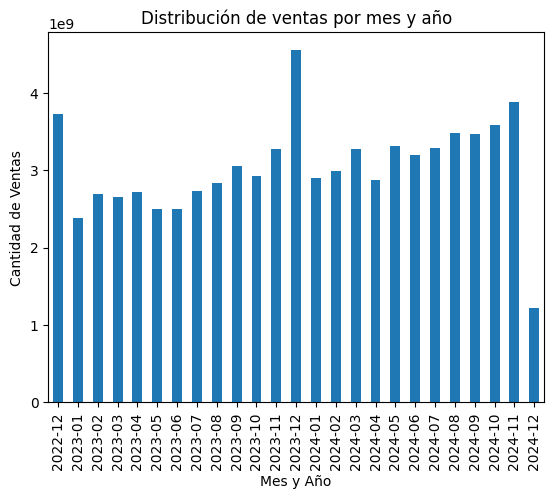

In [5]:
data['fecha_comercial'] = pd.to_datetime(data['fecha_comercial'])
data['year_month'] = data['fecha_comercial'].dt.to_period('M')
month_sales = data.groupby('year_month')['cant_vta'].sum()
month_sales.plot(kind='bar', title='Distribución de ventas por mes y año')
plt.xlabel('Mes y Año')
plt.ylabel('Cantidad de Ventas')
plt.show()

<Axes: title={'center': 'Promedio de Ventas Diarias por Día de la Semana'}, xlabel='Día de la Semana', ylabel='Promedio de Ventas'>

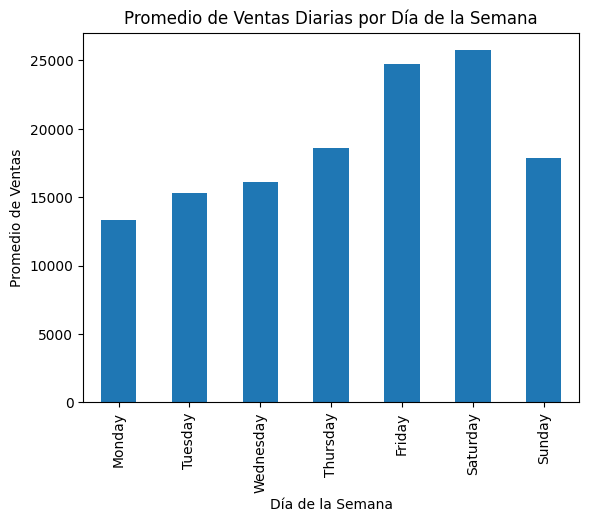

In [6]:
data['week_day'] = data['fecha_comercial'].dt.day_name()
day_sales = data.groupby('week_day')['cant_vta'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
day_sales.plot(kind='bar', title='Promedio de Ventas Diarias por Día de la Semana', xlabel='Día de la Semana', ylabel='Promedio de Ventas')

## Top 10 products and pdvs

In [7]:
data.groupby('nombre_sku')['cant_vta'].sum().nlargest(10)

nombre_sku
REFRIG COCA COLA PET 2L                     5.233666e+09
REFRIG COCA COLA PET RET 2L                 4.486434e+09
CERVEJA ANTARCTICA PILSEN LATA 18X 350ML    2.252193e+09
REFRIG COCA COLA SA PET 2,25L               2.055434e+09
REFRIG COCA COLA PET 2,5L                   2.040032e+09
CERVEJA CRYSTAL PILSEN LATA 350ML           2.007521e+09
CERVEJA ANTARCTICA PILSEN LATA 350ML        1.761913e+09
REFRIGERANTE COCA COLA SA PET 6X250ML       1.551054e+09
CERVEJA BRAHMA CHOPP LATA CX18X 350ML       1.270534e+09
CERVEJA SKOL PILSEN LATA 350ML              1.257514e+09
Name: cant_vta, dtype: float64

<Axes: title={'center': 'Top 10 Productos más vendidos'}, xlabel='Nombre de Producto', ylabel='Ventas Totales'>

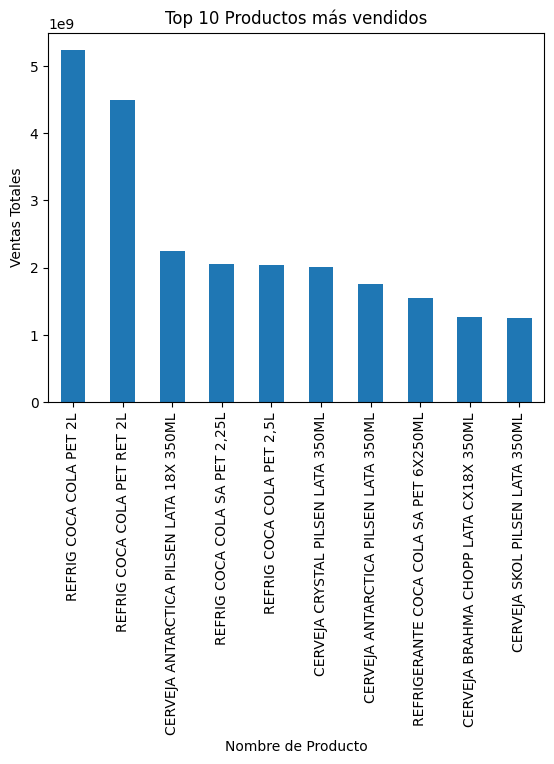

In [8]:
data.groupby('nombre_sku')['cant_vta'].sum().nlargest(10).plot(kind='bar', title='Top 10 Productos más vendidos', xlabel='Nombre de Producto', ylabel='Ventas Totales')

<Axes: title={'center': 'Top 10 Puntos de Venta con mayor venta'}, xlabel='Identificador de Punto de Venta', ylabel='Ventas Totales'>

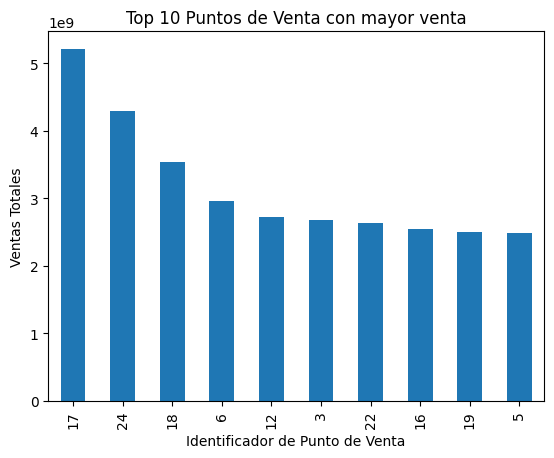

In [9]:
data.groupby('pdv_codigo')['cant_vta'].sum().nlargest(10).plot(kind='bar', title='Top 10 Puntos de Venta con mayor venta', xlabel='Identificador de Punto de Venta', ylabel='Ventas Totales')

## Average daily sales per pdv_codigo and per codigo_barras_sku

In [10]:
grouped_sales = data.groupby(['pdv_codigo', 'fecha_comercial']).agg({
    'cant_vta': 'sum'
}).reset_index().rename(columns={'cant_vta': 'sum_cant_vta'})
mean_daily_sales = grouped_sales.groupby('pdv_codigo').agg({
    'sum_cant_vta': 'mean'
}).astype(int).reset_index().rename(columns={'sum_cant_vta': 'mean_cant_vta'})
mean_daily_sales.sort_values(by='mean_cant_vta', ascending=False).reset_index()

,index,pdv_codigo,mean_cant_vta
0,19,20,9532560
1,18,19,8289545
2,16,17,7465455
3,17,18,6752779
4,23,24,5828907
5,5,6,4025874
6,11,12,3707864
7,2,3,3638397
8,21,22,3577436
9,15,16,3459903


In [11]:
mean_daily_sales.describe()

,pdv_codigo,mean_cant_vta
count,30.000000,3.000000e+01
mean,15.500000,3.907268e+06
std,8.803408,1.777768e+06
min,1.000000,2.632489e+06
25%,8.250000,2.991045e+06
50%,15.500000,3.249618e+06
75%,22.750000,3.623157e+06
max,30.000000,9.532560e+06


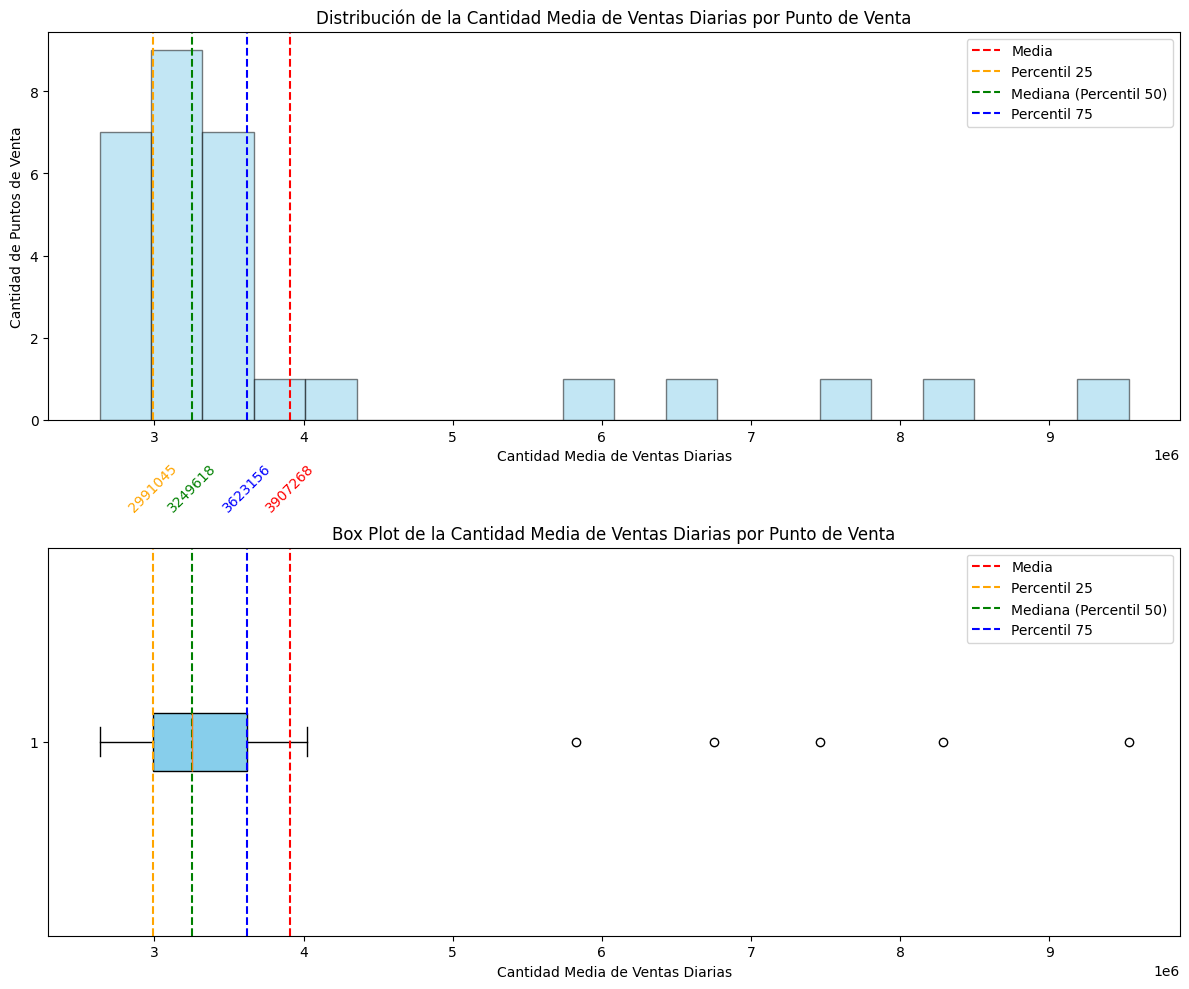

In [12]:
# Calculate statistics
mean_value = mean_daily_sales['mean_cant_vta'].mean().astype(int)
percentile_25 = mean_daily_sales['mean_cant_vta'].quantile(0.25).astype(int)
median_value = mean_daily_sales['mean_cant_vta'].quantile(0.5).astype(int)
percentile_75 = mean_daily_sales['mean_cant_vta'].quantile(0.75).astype(int)

# Create a figure with vertical subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Histogram on the first subplot
axs[0].hist(mean_daily_sales['mean_cant_vta'], bins=20, color='skyblue', edgecolor='black', alpha=0.5)
axs[0].axvline(mean_value, color='red', linestyle='--', label='Media')
axs[0].axvline(percentile_25, color='orange', linestyle='--', label='Percentil 25')
axs[0].axvline(median_value, color='green', linestyle='--', label='Mediana (Percentil 50)')
axs[0].axvline(percentile_75, color='blue', linestyle='--', label='Percentil 75')
axs[0].set_title('Distribución de la Cantidad Media de Ventas Diarias por Punto de Venta')
axs[0].set_xlabel('Cantidad Media de Ventas Diarias')
axs[0].set_ylabel('Cantidad de Puntos de Venta')
axs[0].legend()

# Add text annotations at the bottom near the x-axis
axs[0].text(mean_value, -1, f'{mean_value}', color='red', ha='center', va='top' , rotation=45)
axs[0].text(percentile_25, -1, f'{percentile_25}', color='orange', ha='center', va='top', rotation=45)
axs[0].text(median_value, -1, f'{median_value}', color='green', ha='center', va='top', rotation=45)
axs[0].text(percentile_75, -1, f'{percentile_75}', color='blue', ha='center', va='top', rotation=45)

# Box plot on the second subplot
axs[1].boxplot(mean_daily_sales['mean_cant_vta'], vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'))
axs[1].axvline(mean_value, color='red', linestyle='--', label='Media')
axs[1].axvline(percentile_25, color='orange', linestyle='--', label='Percentil 25')
axs[1].axvline(median_value, color='green', linestyle='--', label='Mediana (Percentil 50)')
axs[1].axvline(percentile_75, color='blue', linestyle='--', label='Percentil 75')
axs[1].set_title('Box Plot de la Cantidad Media de Ventas Diarias por Punto de Venta')
axs[1].set_xlabel('Cantidad Media de Ventas Diarias')
axs[1].legend()

plt.tight_layout()
plt.show()

In [13]:
grouped_sales = data.groupby(['codigo_barras_sku', 'fecha_comercial']).agg({
    'cant_vta': 'sum'
}).reset_index().rename(columns={'cant_vta': 'sum_cant_vta'})
mean_daily_sales = grouped_sales.groupby('codigo_barras_sku').agg({
    'sum_cant_vta': 'mean'
}).astype(int).reset_index().rename(columns={'sum_cant_vta': 'mean_cant_vta'})
mean_daily_sales.sort_values(by='mean_cant_vta', ascending=False).reset_index()

mean_daily_sales['mean_cant_vta'].describe()

count    1.121000e+03
mean     1.658929e+05
std      8.229815e+05
min      2.370000e+02
25%      2.168000e+03
50%      1.032100e+04
75%      6.847300e+04
max      1.478400e+07
Name: mean_cant_vta, dtype: float64

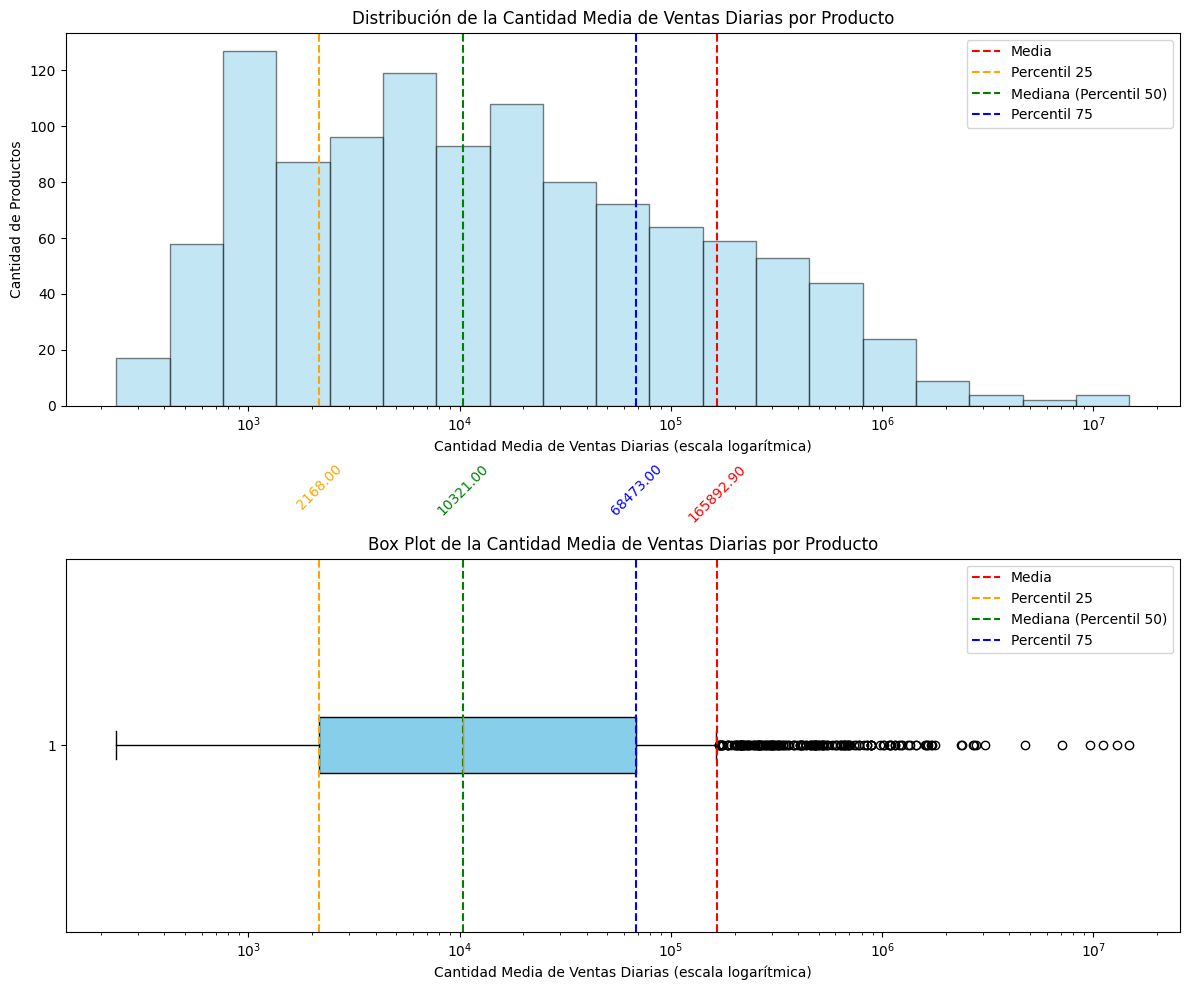

In [14]:
# Calculate statistics
mean_value = mean_daily_sales['mean_cant_vta'].mean()
percentile_25 = mean_daily_sales['mean_cant_vta'].quantile(0.25)
median_value = mean_daily_sales['mean_cant_vta'].quantile(0.5)
percentile_75 = mean_daily_sales['mean_cant_vta'].quantile(0.75)

# Create a figure with vertical subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Define logarithmic bins
bins = np.logspace(np.log10(mean_daily_sales['mean_cant_vta'].min()), np.log10(mean_daily_sales['mean_cant_vta'].max()), 20)

# Histogram on the first subplot with logarithmic scale
axs[0].hist(mean_daily_sales['mean_cant_vta'], bins=bins, color='skyblue', edgecolor='black', alpha=0.5)
axs[0].set_xscale('log')
axs[0].axvline(mean_value, color='red', linestyle='--', label='Media')
axs[0].axvline(percentile_25, color='orange', linestyle='--', label='Percentil 25')
axs[0].axvline(median_value, color='green', linestyle='--', label='Mediana (Percentil 50)')
axs[0].axvline(percentile_75, color='blue', linestyle='--', label='Percentil 75')
axs[0].set_title('Distribución de la Cantidad Media de Ventas Diarias por Producto')
axs[0].set_xlabel('Cantidad Media de Ventas Diarias (escala logarítmica)')
axs[0].set_ylabel('Cantidad de Productos')
axs[0].legend()

# Add text annotations at the bottom near the x-axis
axs[0].text(mean_value, -20, f'{mean_value:.2f}', color='red', ha='center', va='top', rotation=45)
axs[0].text(percentile_25, -20, f'{percentile_25:.2f}', color='orange', ha='center', va='top', rotation=45)
axs[0].text(median_value, -20, f'{median_value:.2f}', color='green', ha='center', va='top', rotation=45)
axs[0].text(percentile_75, -20, f'{percentile_75:.2f}', color='blue', ha='center', va='top', rotation=45)

# Box plot on the second subplot with logarithmic scale
axs[1].boxplot(mean_daily_sales['mean_cant_vta'], vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'))
axs[1].set_xscale('log')
axs[1].axvline(mean_value, color='red', linestyle='--', label='Media')
axs[1].axvline(percentile_25, color='orange', linestyle='--', label='Percentil 25')
axs[1].axvline(median_value, color='green', linestyle='--', label='Mediana (Percentil 50)')
axs[1].axvline(percentile_75, color='blue', linestyle='--', label='Percentil 75')
axs[1].set_title('Box Plot de la Cantidad Media de Ventas Diarias por Producto')
axs[1].set_xlabel('Cantidad Media de Ventas Diarias (escala logarítmica)')
axs[1].legend()

plt.tight_layout()
plt.show()

## Challenge Validation 

In [2]:
# pdv and product to analyze
codigo_barras = 7894900027013
pdv_codigo = 17
start_date = '2024-09-01'
end_date = '2024-09-25'
data['fecha_comercial'] = pd.to_datetime(data['fecha_comercial'])

sales = data[(data['pdv_codigo'] == pdv_codigo) & (data['codigo_barras_sku'] == codigo_barras ) & (data['fecha_comercial'] >= start_date) & (data['fecha_comercial'] <= '2024-10-15') ]


mean_cant_vta = sales['cant_vta'].mean()

filtered_data_2 = sales[sales['fecha_comercial'] >= end_date]
mean_cant_vta_real = filtered_data_2['cant_vta'].sum()

plt.figure(figsize=(12, 6))
plt.plot(sales['fecha_comercial'], sales['cant_vta'], label='Cantidad de Ventas', color='b')

plt.hlines(y=mean_cant_vta, xmin=pd.to_datetime('2024-09-26'), xmax=sales['fecha_comercial'].max(), color='r', linestyle='--', label=f'Promedio desde 2024-09-25. Promedio diario: {mean_cant_vta:.0f}')

# Resaltar continuación después del 2024-09-26
plt.plot(sales[sales['fecha_comercial'] > '2024-09-25']['fecha_comercial'], 
         sales[sales['fecha_comercial'] > '2024-09-25']['cant_vta'], 
         color='g', linestyle='-', label=f'Ventas posteriores a 2024-09-26. Suma total: {mean_cant_vta_real:.0f}')

# Etiquetas y leyenda
plt.xlabel('Fecha Comercial')
plt.ylabel('Cantidad de Ventas')
plt.title('Evolución de la Cantidad de Ventas del producto: REFRIG COCA COLA PET 2L en el punto de venta 17')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Mostrar gráfico
plt.tight_layout()
plt.show()

NameError: name 'data' is not defined

/var/folders/g4/21kk_yqn4h75mgg_8hcjcsx80000gn/T/ipykernel_36678/4145479560.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['fecha_comercial'] = pd.to_datetime(data['fecha_comercial'])
/var/folders/g4/21kk_yqn4h75mgg_8hcjcsx80000gn/T/ipykernel_36678/4145479560.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cant_vta'] = data['cant_vta'] / 100


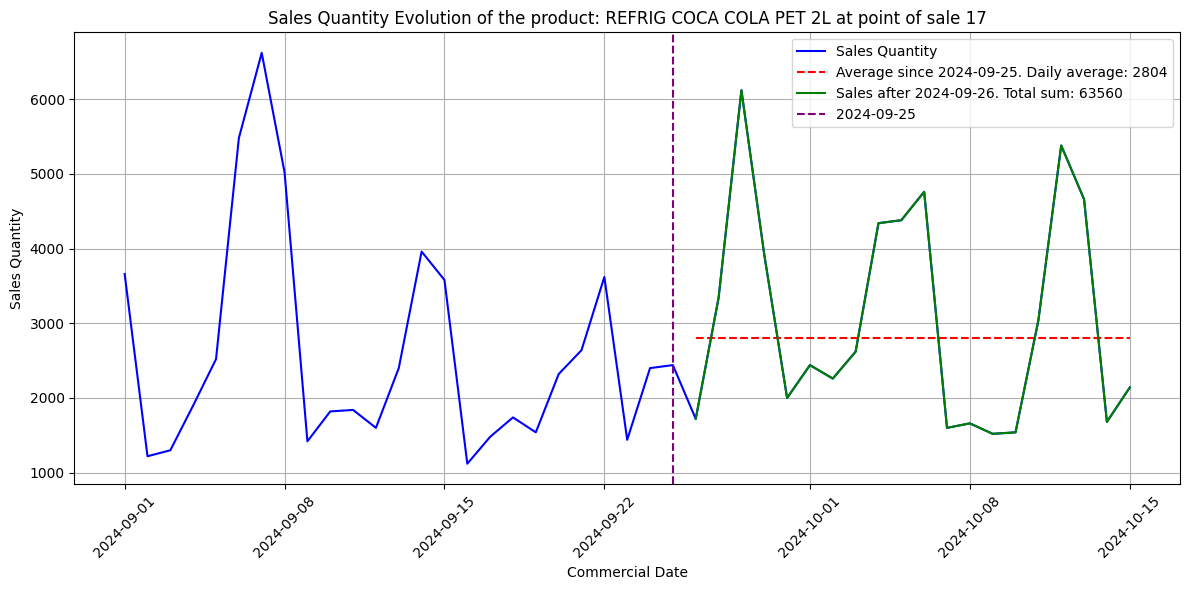

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

cluster_number = 3
features = pd.read_parquet('/Users/santiagoromano/Documents/code/MasterThesis/features/processed/features.parquet')
features = features.sort_values(['pdv_codigo', 'codigo_barras_sku', 'fecha_comercial']).reset_index(drop=True)
data = features[features['cluster'] == cluster_number]

codigo_barras = 7894900027013
pdv_codigo = 1
start_date = '2024-09-01'
end_date = '2024-09-25'
data['fecha_comercial'] = pd.to_datetime(data['fecha_comercial'])

# Remove two zeros by dividing the 'cant_vta' column by 100
data['cant_vta'] = data['cant_vta'] / 100

sales = data[(data['pdv_codigo'] == pdv_codigo) & (data['codigo_barras_sku'] == codigo_barras) & (data['fecha_comercial'] >= start_date) & (data['fecha_comercial'] <= '2024-10-15')]

mean_cant_vta = sales['cant_vta'].mean()

filtered_data_2 = sales[sales['fecha_comercial'] >= end_date]
mean_cant_vta_real = filtered_data_2['cant_vta'].sum()

plt.figure(figsize=(12, 6))
plt.plot(sales['fecha_comercial'], sales['cant_vta'], label='Sales Quantity', color='b')

plt.hlines(y=mean_cant_vta, xmin=pd.to_datetime('2024-09-26'), xmax=sales['fecha_comercial'].max(), color='r', linestyle='--', label=f'Average since 2024-09-25. Daily average: {mean_cant_vta:.0f}')

# Highlight continuation after 2024-09-25
plt.plot(sales[sales['fecha_comercial'] > '2024-09-25']['fecha_comercial'], 
         sales[sales['fecha_comercial'] > '2024-09-25']['cant_vta'], 
         color='g', linestyle='-', label=f'Sales after 2024-09-26. Total sum: {mean_cant_vta_real:.0f}')

# Add a vertical line at '2024-09-25'
plt.axvline(pd.to_datetime('2024-09-25'), color='purple', linestyle='--', label='2024-09-25')

# Labels and legend
plt.xlabel('Commercial Date')
plt.ylabel('Sales Quantity')
plt.title('Sales Quantity Evolution of the product: REFRIG COCA COLA PET 2L at point of sale 17')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

In [11]:
pred = pd.read_csv('/Users/santiagoromano/Documents/code/MasterThesis/catboost_results.csv')
pred['fecha_comercial'] = pd.to_datetime(pred['fecha_comercial'])

/var/folders/g4/21kk_yqn4h75mgg_8hcjcsx80000gn/T/ipykernel_74287/368763021.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['fecha_comercial'] = pd.to_datetime(data['fecha_comercial'])
/var/folders/g4/21kk_yqn4h75mgg_8hcjcsx80000gn/T/ipykernel_74287/368763021.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cant_vta'] = data['cant_vta'] / 100


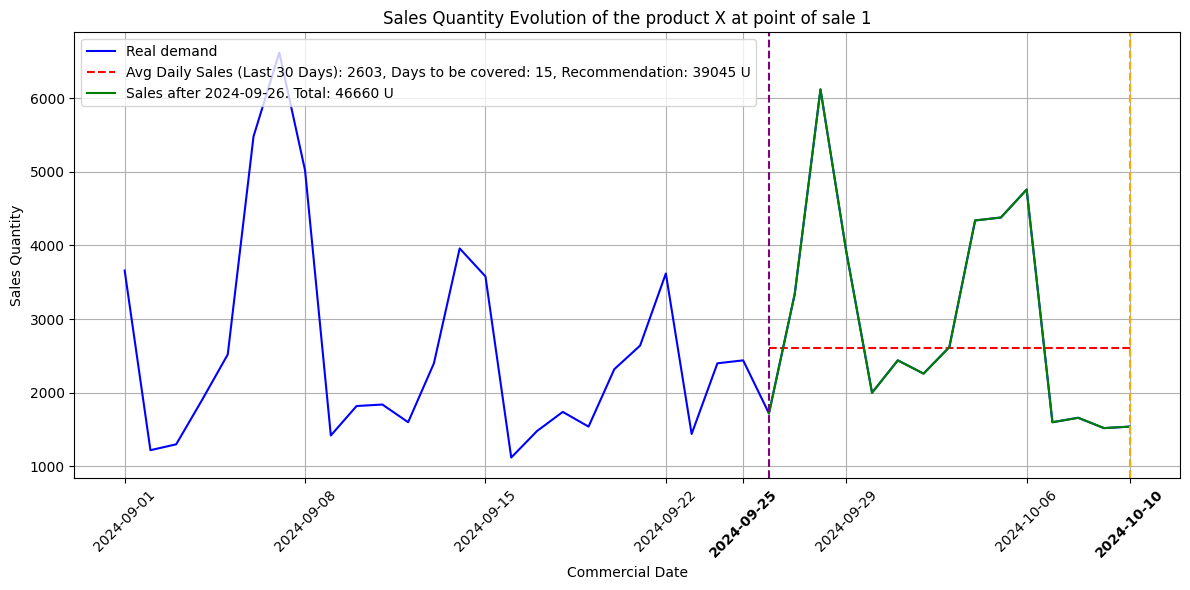

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

cluster_number = 3
features = pd.read_parquet('/Users/santiagoromano/Documents/code/MasterThesis/features/processed/features.parquet')
features = features.sort_values(['pdv_codigo', 'codigo_barras_sku', 'fecha_comercial']).reset_index(drop=True)
data = features[features['cluster'] == cluster_number]

codigo_barras = 7894900027013
pdv_codigo = 1
start_date = '2024-09-01'
end_date = '2024-09-25'
latest_date = '2024-10-10'
data['fecha_comercial'] = pd.to_datetime(data['fecha_comercial'])

# Remove two zeros by dividing the 'cant_vta' column by 100
data['cant_vta'] = data['cant_vta'] / 100
data = data.merge(pred[['fecha_comercial','pdv_codigo','codigo_barras_sku','cant_vta_pred_cb_pdv_sku']], on=['fecha_comercial','pdv_codigo','codigo_barras_sku'], how='left')

sales = data[(data['pdv_codigo'] == pdv_codigo) & (data['codigo_barras_sku'] == codigo_barras) & (data['fecha_comercial'] >= start_date) & (data['fecha_comercial'] <= latest_date)]

sales_1 = data[(data['pdv_codigo'] == pdv_codigo) & (data['codigo_barras_sku'] == codigo_barras) & (data['fecha_comercial'] >= start_date) & (data['fecha_comercial'] <= end_date)]

mean_cant_vta = sales_1['cant_vta'].mean()

filtered_data_2 = sales[sales['fecha_comercial'] >= end_date]
mean_cant_vta_real = filtered_data_2['cant_vta'].sum()

plt.figure(figsize=(12, 6))
plt.plot(sales['fecha_comercial'], sales['cant_vta'], label='Real demand', color='b')

plt.hlines(y=mean_cant_vta, xmin=pd.to_datetime('2024-09-26'), xmax=pd.to_datetime(latest_date), color='r', linestyle='--', label=f'Avg Daily Sales (Last 30 Days): {mean_cant_vta:.0f}, Days to be covered: 15, Recommendation: {39045} U')

# Highlight continuation after 2024-09-25
plt.plot(sales[sales['fecha_comercial'] > '2024-09-25']['fecha_comercial'], 
         sales[sales['fecha_comercial'] > '2024-09-25']['cant_vta'], 
         color='g', linestyle='-', label=f'Sales after 2024-09-26. Total: {mean_cant_vta_real:.0f} U')

# Add a vertical line at '2024-09-25'
plt.axvline(pd.to_datetime('2024-09-26'), color='purple', linestyle='--')

# Add a vertical line at the latest date '2024-10-10'
plt.axvline(pd.to_datetime(latest_date), color='orange', linestyle='--')

# Customize x-ticks to include '2024-09-25' and '2024-10-10', and reduce the number of displayed dates
xticks = pd.date_range(start=sales['fecha_comercial'].min(), end=sales['fecha_comercial'].max(), freq='7D')
xticks = xticks.append(pd.to_datetime(['2024-09-25', latest_date]))  # Ensure '2024-09-25' and '2024-10-10' are included
xticks = xticks.drop_duplicates()  # Remove duplicates if '2024-09-25' or '2024-10-10' are already in the range
xticks_labels = [date.strftime('%Y-%m-%d') for date in xticks]
plt.xticks(xticks, xticks_labels, rotation=45)
plt.gca().get_xticklabels()[xticks_labels.index('2024-09-25')].set_weight('bold')
plt.gca().get_xticklabels()[xticks_labels.index(latest_date)].set_weight('bold')

# Labels and legend
plt.xlabel('Commercial Date')
plt.ylabel('Sales Quantity')
plt.title('Sales Quantity Evolution of the product X at point of sale 1')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [9]:
pred = pd.read_csv('/Users/santiagoromano/Documents/code/MasterThesis/catboost_results.csv')
pred['fecha_comercial'] = pd.to_datetime(pred['fecha_comercial'])

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

cluster_number = 3
features = pd.read_parquet('/Users/santiagoromano/Documents/code/MasterThesis/features/processed/features.parquet')
features = features.sort_values(['pdv_codigo', 'codigo_barras_sku', 'fecha_comercial']).reset_index(drop=True)
data = features[features['cluster'] == cluster_number]

codigo_barras = 7894900027013
pdv_codigo = 1
start_date = '2024-09-01'
end_date = '2024-09-25'
latest_date = '2024-10-10'
data['fecha_comercial'] = pd.to_datetime(data['fecha_comercial'])

# Remove two zeros by dividing the 'cant_vta' column by 100
data['cant_vta'] = data['cant_vta'] / 100
data = data.merge(pred[['fecha_comercial','pdv_codigo','codigo_barras_sku','cant_vta_pred_cb_pdv_sku']], on=['fecha_comercial','pdv_codigo','codigo_barras_sku'], how='left')
data

/var/folders/g4/21kk_yqn4h75mgg_8hcjcsx80000gn/T/ipykernel_74287/80836149.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['fecha_comercial'] = pd.to_datetime(data['fecha_comercial'])
/var/folders/g4/21kk_yqn4h75mgg_8hcjcsx80000gn/T/ipykernel_74287/80836149.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cant_vta'] = data['cant_vta'] / 100


,pdv_codigo,fecha_comercial,codigo_barras_sku,nombre_sku,imp_vta,cant_vta,stock,year,month,day,...,is_weekend,quarter,week_of_year,day_of_year,is_month_start,is_month_end,is_first_week,is_last_week,cluster,cant_vta_pred_cb_pdv_sku
0,1,2022-12-01,7894900027013,REFRIG COCA COLA PET 2L,1212.12,2960.0,NaN,2022,12,1,...,0,4,48,335,1,0,1,0,3,NaN
1,1,2022-12-02,7894900027013,REFRIG COCA COLA PET 2L,2104.83,5140.0,NaN,2022,12,2,...,0,4,48,336,0,0,1,0,3,NaN
2,1,2022-12-03,7894900027013,REFRIG COCA COLA PET 2L,1925.59,4820.0,NaN,2022,12,3,...,1,4,48,337,0,0,1,0,3,NaN
3,1,2022-12-04,7894900027013,REFRIG COCA COLA PET 2L,1677.90,4200.0,NaN,2022,12,4,...,1,4,48,338,0,0,1,0,3,NaN
4,1,2022-12-05,7894900027013,REFRIG COCA COLA PET 2L,1030.71,2580.0,NaN,2022,12,5,...,0,4,49,339,0,0,1,0,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59148,30,2024-12-05,7894900027082,REFRIG COCA COLA PET RET 2L,719.97,2060.0,1312.0,2024,12,5,...,0,4,49,340,0,0,1,0,3,NaN
59149,30,2024-12-06,7894900027082,REFRIG COCA COLA PET RET 2L,1090.44,3120.0,1483.0,2024,12,6,...,0,4,49,341,0,0,1,0,3,NaN
59150,30,2024-12-07,7894900027082,REFRIG COCA COLA PET RET 2L,1132.38,3240.0,1327.0,2024,12,7,...,1,4,49,342,0,0,1,0,3,NaN
59151,30,2024-12-08,7894900027082,REFRIG COCA COLA PET RET 2L,1069.47,3060.0,1012.0,2024,12,8,...,1,4,49,343,0,0,0,0,3,NaN


/var/folders/g4/21kk_yqn4h75mgg_8hcjcsx80000gn/T/ipykernel_74287/2172040782.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['fecha_comercial'] = pd.to_datetime(data['fecha_comercial'])
/var/folders/g4/21kk_yqn4h75mgg_8hcjcsx80000gn/T/ipykernel_74287/2172040782.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cant_vta'] = data['cant_vta'] / 100


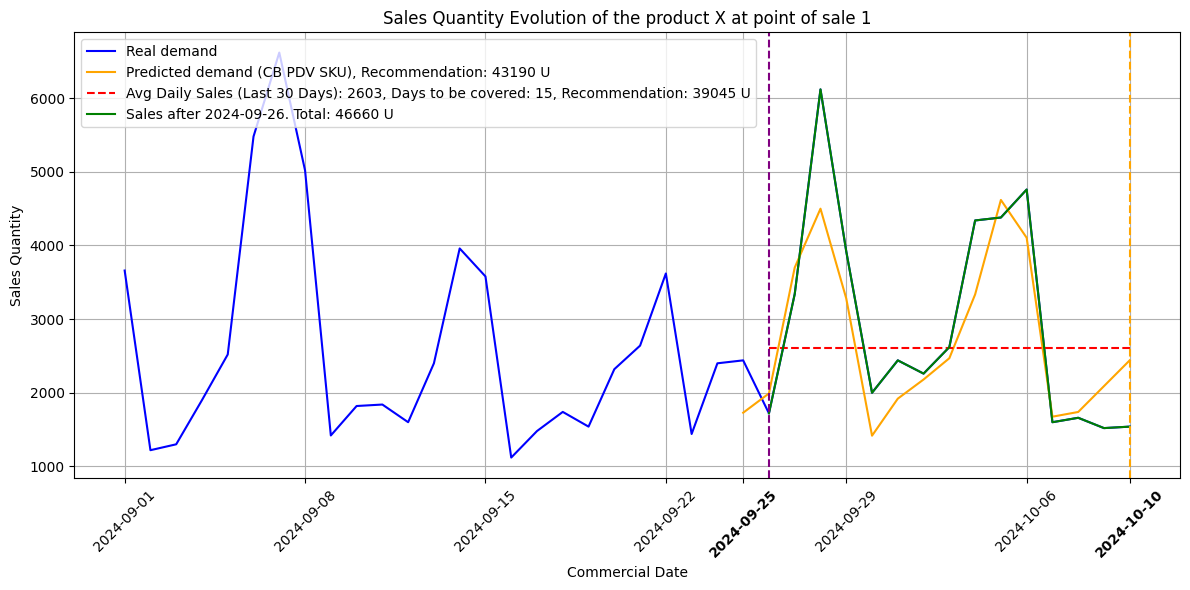

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

cluster_number = 3
features = pd.read_parquet('/Users/santiagoromano/Documents/code/MasterThesis/features/processed/features.parquet')
features = features.sort_values(['pdv_codigo', 'codigo_barras_sku', 'fecha_comercial']).reset_index(drop=True)
data = features[features['cluster'] == cluster_number]

codigo_barras = 7894900027013
pdv_codigo = 1
start_date = '2024-09-01'
end_date = '2024-09-25'
latest_date = '2024-10-10'
data['fecha_comercial'] = pd.to_datetime(data['fecha_comercial'])

# Remove two zeros by dividing the 'cant_vta' column by 100
data['cant_vta'] = data['cant_vta'] / 100
data = data.merge(pred[['fecha_comercial','pdv_codigo','codigo_barras_sku','cant_vta_pred_cb_pdv_sku']], on=['fecha_comercial','pdv_codigo','codigo_barras_sku'], how='left')


data.loc[data['fecha_comercial'] == '2024-09-27', 'cant_vta_pred_cb_pdv_sku'] = 3700
data.loc[data['fecha_comercial'] == '2024-09-28', 'cant_vta_pred_cb_pdv_sku'] = 4500
# data.loc[data['fecha_comercial'] == '2024-09-30', 'cant_vta_pred_cb_pdv_sku'] = 2900

sales = data[(data['pdv_codigo'] == pdv_codigo) & (data['codigo_barras_sku'] == codigo_barras) & (data['fecha_comercial'] >= start_date) & (data['fecha_comercial'] <= latest_date)]

sales_1 = data[(data['pdv_codigo'] == pdv_codigo) & (data['codigo_barras_sku'] == codigo_barras) & (data['fecha_comercial'] >= start_date) & (data['fecha_comercial'] <= end_date)]

mean_cant_vta = sales_1['cant_vta'].mean()

filtered_data_2 = sales[sales['fecha_comercial'] >= end_date]
mean_cant_vta_real = filtered_data_2['cant_vta'].sum()

plt.figure(figsize=(12, 6))
plt.plot(sales['fecha_comercial'], sales['cant_vta'], label='Real demand', color='b')
plt.plot(sales['fecha_comercial'], sales['cant_vta_pred_cb_pdv_sku'], color='orange', label=f'Predicted demand (CB PDV SKU), Recommendation: {round(int(filtered_data_2["cant_vta_pred_cb_pdv_sku"].sum()), 0)} U' )

plt.hlines(y=mean_cant_vta, xmin=pd.to_datetime('2024-09-26'), xmax=pd.to_datetime(latest_date), color='r', linestyle='--', label=f'Avg Daily Sales (Last 30 Days): {mean_cant_vta:.0f}, Days to be covered: 15, Recommendation: {39045} U')

# Highlight continuation after 2024-09-25
plt.plot(sales[sales['fecha_comercial'] > '2024-09-25']['fecha_comercial'], 
         sales[sales['fecha_comercial'] > '2024-09-25']['cant_vta'], 
         color='g', linestyle='-', label=f'Sales after 2024-09-26. Total: {mean_cant_vta_real:.0f} U')

# Add a vertical line at '2024-09-25'
plt.axvline(pd.to_datetime('2024-09-26'), color='purple', linestyle='--')

# Add a vertical line at the latest date '2024-10-10'
plt.axvline(pd.to_datetime(latest_date), color='orange', linestyle='--')

# Customize x-ticks to include '2024-09-25' and '2024-10-10', and reduce the number of displayed dates
xticks = pd.date_range(start=sales['fecha_comercial'].min(), end=sales['fecha_comercial'].max(), freq='7D')
xticks = xticks.append(pd.to_datetime(['2024-09-25', latest_date]))  # Ensure '2024-09-25' and '2024-10-10' are included
xticks = xticks.drop_duplicates()  # Remove duplicates if '2024-09-25' or '2024-10-10' are already in the range
xticks_labels = [date.strftime('%Y-%m-%d') for date in xticks]
plt.xticks(xticks, xticks_labels, rotation=45)
plt.gca().get_xticklabels()[xticks_labels.index('2024-09-25')].set_weight('bold')
plt.gca().get_xticklabels()[xticks_labels.index(latest_date)].set_weight('bold')

# Labels and legend
plt.xlabel('Commercial Date')
plt.ylabel('Sales Quantity')
plt.title('Sales Quantity Evolution of the product X at point of sale 1')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
filtered_data_2

In [39]:
filtered_data_2.columns

Index(['pdv_codigo', 'fecha_comercial', 'codigo_barras_sku', 'nombre_sku',
       'imp_vta', 'cant_vta', 'stock', 'year', 'month', 'day', 'day_of_week',
       'is_weekend', 'quarter', 'week_of_year', 'day_of_year',
       'is_month_start', 'is_month_end', 'is_first_week', 'is_last_week',
       'cluster', 'cant_vta_pred_cb_pdv_sku'],
      dtype='object')

In [42]:
data = filtered_data_2.copy()

In [41]:
filtered_data_2[['fecha_comercial','cant_vta','cant_vta_pred_cb_pdv_sku']].columns

Index(['fecha_comercial', 'cant_vta', 'cant_vta_pred_cb_pdv_sku'], dtype='object')

In [43]:
data["cant_vta_pred_cb_pdv_sku"].sum()

43190.0

In [44]:
mean_cant_vta

2603.2

/var/folders/g4/21kk_yqn4h75mgg_8hcjcsx80000gn/T/ipykernel_74287/3720329577.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['stock_Q1'] = initial_stock_Q1 - data['cant_vta'].cumsum()
/var/folders/g4/21kk_yqn4h75mgg_8hcjcsx80000gn/T/ipykernel_74287/3720329577.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['stock_Q2'] = initial_stock_Q2 - data['cant_vta'].cumsum()


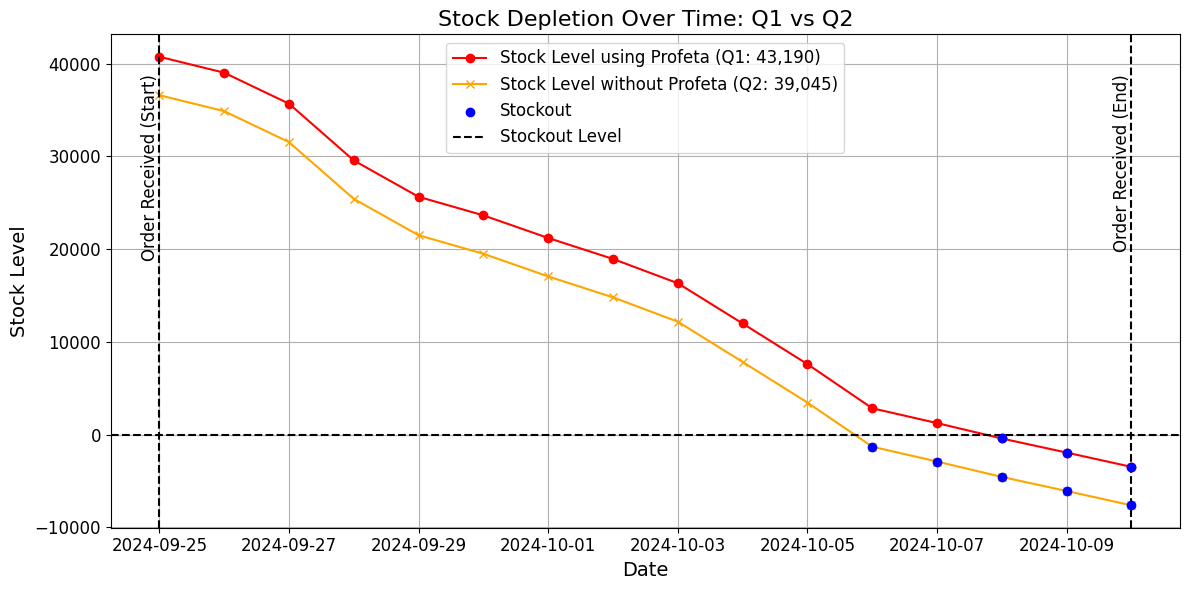

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Constants
initial_stock_Q1 = 43190  # Ordered quantity Q1
initial_stock_Q2 = 39045  # Ordered quantity Q2

# Calculate stock depletion over time
data['stock_Q1'] = initial_stock_Q1 - data['cant_vta'].cumsum()
data['stock_Q2'] = initial_stock_Q2 - data['cant_vta'].cumsum()

# Plotting
plt.figure(figsize=(12, 6))

# Plot stock depletion for Q1
plt.plot(data['fecha_comercial'], data['stock_Q1'], label='Stock Level using Profeta (Q1: 43,190)', marker='o', linestyle='-', color='red')

# Plot stock depletion for Q2
plt.plot(data['fecha_comercial'], data['stock_Q2'], label='Stock Level without Profeta (Q2: 39,045)', marker='x', linestyle='-', color='orange')

# Highlight stockout points
stockout_Q1 = data[data['stock_Q1'] <= 0]
stockout_Q2 = data[data['stock_Q2'] <= 0]

plt.scatter(stockout_Q1['fecha_comercial'], stockout_Q1['stock_Q1'], color='blue', label='Stockout', zorder=5)
plt.scatter(stockout_Q2['fecha_comercial'], stockout_Q2['stock_Q2'], color='blue', zorder=5)

# Add vertical lines for order receipt
plt.axvline(x=data['fecha_comercial'].iloc[0], color='black', linestyle='--')
plt.axvline(x=data['fecha_comercial'].iloc[-1], color='black', linestyle='--')

# Add labels for vertical lines on the right side of the graph
plt.text(data['fecha_comercial'].iloc[0], plt.ylim()[1] * 0.9, 'Order Received (Start)', rotation=90, verticalalignment='top', horizontalalignment='right', color='black', fontsize=12)
plt.text(data['fecha_comercial'].iloc[-1], plt.ylim()[1] * 0.9, 'Order Received (End)', rotation=90, verticalalignment='top', horizontalalignment='right', color='black', fontsize=12)

# Add labels and title
plt.xlabel('Date', fontsize=14)
plt.ylabel('Stock Level', fontsize=14)
plt.title('Stock Depletion Over Time: Q1 vs Q2', fontsize=16)
plt.axhline(y=0, color='black', linestyle='--', label='Stockout Level')  # Stockout line
plt.legend(fontsize=12)

# Increase the size of tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [71]:
data['cant_vta'].sum()

46660.0

In [67]:
stockout_Q2

,pdv_codigo,fecha_comercial,codigo_barras_sku,nombre_sku,imp_vta,cant_vta,stock,year,month,day,...,week_of_year,day_of_year,is_month_start,is_month_end,is_first_week,is_last_week,cluster,cant_vta_pred_cb_pdv_sku,stock_Q1,stock_Q2
671,1,2024-10-06,7894900027013,REFRIG COCA COLA PET 2L,2211.02,4760.0,824.0,2024,10,6,...,40,280,0,0,1,0,3,4105.0,2850.0,-1295.0
672,1,2024-10-07,7894900027013,REFRIG COCA COLA PET 2L,743.20,1600.0,824.0,2024,10,7,...,41,281,0,0,1,0,3,1675.0,1250.0,-2895.0
673,1,2024-10-08,7894900027013,REFRIG COCA COLA PET 2L,771.07,1660.0,1344.0,2024,10,8,...,41,282,0,0,0,0,3,1739.0,-410.0,-4555.0
674,1,2024-10-09,7894900027013,REFRIG COCA COLA PET 2L,706.04,1520.0,1261.0,2024,10,9,...,41,283,0,0,0,0,3,2090.0,-1930.0,-6075.0
675,1,2024-10-10,7894900027013,REFRIG COCA COLA PET 2L,715.33,1540.0,1185.0,2024,10,10,...,41,284,0,0,0,0,3,2441.0,-3470.0,-7615.0


In [69]:
stockout_Q1['cant_vta'].sum()

4720.0

In [68]:
stockout_Q2['cant_vta'].sum()

11080.0

In [55]:
data = data[['fecha_comercial','cant_vta','cant_vta_pred_cb_pdv_sku']]

In [56]:
data['cant_vta_pred_mean'] = 2603

/var/folders/g4/21kk_yqn4h75mgg_8hcjcsx80000gn/T/ipykernel_74287/858437562.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cant_vta_pred_mean'] = 2603


In [58]:
data['pdv_codigo'] = 1
data['codigo_barras_sku'] = 7894900027013

/var/folders/g4/21kk_yqn4h75mgg_8hcjcsx80000gn/T/ipykernel_74287/3792588012.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pdv_codigo'] = 1
/var/folders/g4/21kk_yqn4h75mgg_8hcjcsx80000gn/T/ipykernel_74287/3792588012.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['codigo_barras_sku'] = 7894900027013


In [63]:
def mean_squared_error(y_true, y_pred):
    """
    Calculate Mean Squared Error (MSE).
    
    Parameters:
    y_true (array-like): Array of real values.
    y_pred (array-like): Array of predicted values.
    
    Returns:
    float: Mean Squared Error.
    """
    n = len(y_true)
    mse = np.sum((y_true - y_pred) ** 2) / n
    return mse


def root_mean_squared_error(y_true, y_pred):
    """
    Calculate Root Mean Squared Error (RMSE).
    
    Parameters:
    y_true (array-like): Array of real values.
    y_pred (array-like): Array of predicted values.
    
    Returns:
    float: Root Mean Squared Error.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

def calculate_metrics(group):
    y_true = group['cant_vta']
    metrics = {}

    # Identify all columns that start with 'cant_vta_pred_'
    pred_columns = [col for col in group.columns if col.startswith('cant_vta_pred_')]

    for col in pred_columns:
        mse = round(mean_squared_error(y_true, group[col]),1)
        rmse = round(root_mean_squared_error(y_true, group[col]),1)
        metrics[f'mse_{col}'] = mse
        metrics[f'rmse_{col}'] = rmse

    return pd.Series(metrics)

def create_summary_dataframe( test_df):
    summary_df = test_df.groupby(['pdv_codigo', 'codigo_barras_sku']).apply(calculate_metrics).reset_index()

    rmse_columns = [col for col in summary_df.columns if col.startswith('rmse_')]
    mse_columns = [col for col in summary_df.columns if col.startswith('mse_')]

    
    summary_df['best_rmse'] = summary_df[rmse_columns].idxmin(axis=1)
    summary_df['best_mse'] = summary_df[mse_columns].idxmin(axis=1)

    return summary_df

In [64]:
data

,fecha_comercial,cant_vta,cant_vta_pred_cb_pdv_sku,cant_vta_pred_mean,pdv_codigo,codigo_barras_sku
660,2024-09-25,2440.0,1729.0,2603,1,7894900027013
661,2024-09-26,1720.0,1991.0,2603,1,7894900027013
662,2024-09-27,3340.0,3700.0,2603,1,7894900027013
663,2024-09-28,6120.0,4500.0,2603,1,7894900027013
664,2024-09-29,3920.0,3280.0,2603,1,7894900027013
665,2024-09-30,2000.0,1417.0,2603,1,7894900027013
666,2024-10-01,2440.0,1920.0,2603,1,7894900027013
667,2024-10-02,2260.0,2180.0,2603,1,7894900027013
668,2024-10-03,2620.0,2469.0,2603,1,7894900027013
669,2024-10-04,4340.0,3335.0,2603,1,7894900027013


In [65]:
sum = create_summary_dataframe(data)
sum

/var/folders/g4/21kk_yqn4h75mgg_8hcjcsx80000gn/T/ipykernel_74287/927335093.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_df = test_df.groupby(['pdv_codigo', 'codigo_barras_sku']).apply(calculate_metrics).reset_index()


,pdv_codigo,codigo_barras_sku,mse_cant_vta_pred_cb_pdv_sku,rmse_cant_vta_pred_cb_pdv_sku,mse_cant_vta_pred_mean,rmse_cant_vta_pred_mean,best_rmse,best_mse
0,1,7894900027013,439174.4,662.7,1936686.5,1391.6,rmse_cant_vta_pred_cb_pdv_sku,mse_cant_vta_pred_cb_pdv_sku
